In [1]:
import pandas as pd
import numpy as np

region_names_df = pd.read_csv('/home/nader/source/Language-Navigation/habitat-matterport-3dresearch/statistics/HM3DSem-v0.2/Per_Scene_Region_Weighted_Votes.csv')

region_objects_df = pd.read_csv('/home/nader/source/Language-Navigation/habitat-matterport-3dresearch/statistics/HM3DSem-v0.2/Region_Tag_Mappings.csv')

In [2]:
region_objects_lists = region_objects_df['Relevant Tags in Region (Excluding : window;ceiling;floor;door;unknown;wall;window frame)'].str.split(';')

region_objects = region_objects_lists.explode().unique()

region_objects_binary = [{value: value in row for value in region_objects} for row in region_objects_lists]

region_objects_binary_df = pd.concat([pd.Series(row) for row in region_objects_binary], axis=1).T


In [3]:
# Filtering

region_names = region_names_df['Weighted Room Proposal'].str.strip()

filter = (region_names != 'Unknown room') & ~(region_names.str.startswith('Tie:'))

region_names_filtered = region_names[filter]

region_objects_df_filtered = region_objects_binary_df[filter]

region_names_unique = region_names_filtered.unique()

region_names_dict = {name: i for i, name in enumerate(region_names_unique)}

region_names_numerical = region_names_filtered.map(region_names_dict)

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

np.random.seed(42)

X = np.array(region_objects_df_filtered)
y = np.array(region_names_numerical)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


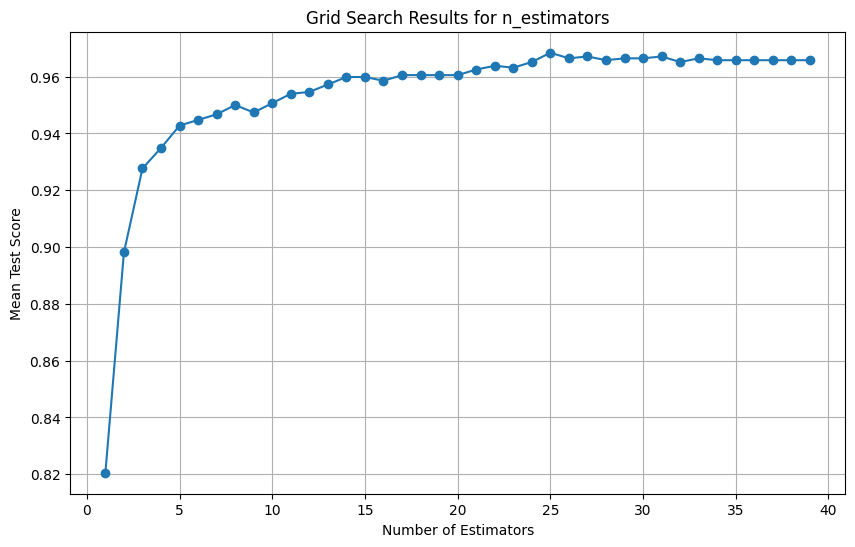

In [8]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


param_grid = {
    'n_estimators': np.arange(1, 40),
}

bst = XGBClassifier(learning_rate=1, max_depth=1, objective='binary:logistic')

grid_search = GridSearchCV(bst, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Convert results to DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results['param_n_estimators'], results['mean_test_score'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results for n_estimators')
plt.grid(True)
plt.show()

In [5]:
bst2 = XGBClassifier(n_estimators = 25, max_depth=1, learning_rate=1, objective='binary:logistic')

bst2.fit(X_train, y_train)

pred = bst2.predict(X_test)

np.mean(pred == y_test)

0.979002624671916

In [6]:
filter_tie = region_names.str.startswith('Tie:')

region_names_tied = region_names[filter_tie].reset_index()['Weighted Room Proposal']

region_objects_df_tied = region_objects_binary_df[filter_tie]

region_objects_original_tied = region_objects_df[filter_tie].reset_index()

pred = bst2.predict(np.array(region_objects_df_tied))

pred_names = pd.Series([region_names_unique[i] for i in pred])

region_objects_original_tied['Tied Names'] = region_names_tied
region_objects_original_tied['Predicted Names'] = pred_names


In [10]:
pred_names[pred_names=='Bedroom'].size

12

In [7]:
region_objects_original_tied.to_csv('tied_disambiguation.csv')